# sMRI Spatial Normalization

---

Objectives:

* Understand reference spaces and registration process.

Reference coordinate spaces and spatial normalization offer a way to map and compare brain anatomy across modalities, individuals, and studies.

## Why do we need spatial normalization

Compare and combine brain images across modalities, individuals, and studies.

## What do we need for spatial normalization

1. A reference frame: A 3D space that assigns `x`, `y`, `z` coordinates to anatomical regions (independent of voxel dimensions).
2. A common template: a single or an average image volume as an alignment target.
3. An image registration algorithm.

### 1. Coordinate systems and spaces

* World coordinates
* Anatomical coordinates
* Image coordinates

![Slicer_Wiki_Coordinate_Systems.png](imgs/Slicer_Wiki_Coordinate_Sytems.png)

#### World coordinates

The world coordinates refer to a Cartesian coordinate system in which an MRI scanner is positioned.

#### Anatomical coordinates

The anatomical space is coordinate system `(X, Y, Z)` that consists of three planes to describe the standard anatomical position of a human

* **Axial** plane is parallel to the ground and separates the head (Superior) from the feed (inferior).
* **Coronal** plane is perpendicular to the ground and separates the front (Anterior) from the back (Posterior).
* **Sagittal** plane separates the Left from the Right.

The origin and direction of anatomical coordinates system are defined by conventions. In neuroimaging the most commonly used definition is the stereotaxic space.

##### Stereotaxic space

* A 3-dimensional coordinate reference frame based on anatomical landmarks -- originally used to guide neurosurgical procedures
  * A/P means anterior/posterior
  * L/R means left/right
  * S/I means superior/inferior
  * Example: `RAS`
    * First dimension `(X)` points towards the right-hand side of the head.
    * Second dimension `(Y)` points towards the Anterior aspect of the head.
    * Third dimension `(Z)` points towards the top of the head.
    * Directions are from the subject's perspective. In the RAS coordinate system, a point to the subject's left will have negative `x` value.
  * Talairach space
    * Derived from a single 60-yr old female cadaver brain
  * MNI space(s)
    * Similar to the original Talairach space but the Z-coordinate has approximately +3.5mm offset relative to the Talairach coordinate.

![MNI space](imgs/MNI_space_offset.png)

### Image coordinates

The image coordinate system `(i, j, k)` describes the acquired image (voxels) with respect to the anatomy. The MR images are 3D voxel arrays whose origin is assigned at the upper left corner. The `i` axis increases to the right, the `j` axis to the bottom and the `k` axis backwards.

Downsampling reduces the number of total voxels in the image. Consequently the voxel-spacing is increased as more anatomical space is "sampled" by any given voxel. Note that the new intensity values of the resampled voxels are determined based on the type of interpolation used.

Dataset used: [AOMIC](https://nilab-uva.github.io/AOMIC.github.io/) the Amsterdam Open MRI Collection.

In [11]:
from bids import BIDSLayout

# Local paths

local_data_dir = 'local_data/'
bids_data_dir = 'local_data/AOMIC/'

bids_layout = BIDSLayout(bids_data_dir, derivatives=True)

subject_id = 'sub-0001' # 'sub-0002'

freesurfer_output_dir = bids_data_dir + 'derivatives/freesurfer/{}/mri/'.format(subject_id)
fsaverage_dir = bids_data_dir + 'derivatives/freesurfer/fsaverage5/mri/'

print(f'Using {subject_id}')

Using sub-0001


## 2. MR image templates

* An anatomical template is an average MR volume whose voxels encode the average probability of different tissue classes at particular spatial location. The template creation is an iterative process comprising normalization, alignment, and averaging of a set of MR images from several different subjects.
* Structural T1w templates serve as a *common reference space* and allow researchers to combine the compare data from multiple subjects.
* Templates play an important role in a variety of neuroimaging tasks:
  * Target image for spatial normalization in voxel-wise analyses
  * Automated intensity based WM, GM, and CSF tissue-segmentation of MR images
  * Anatomical atlas creation for region of interest analyses
  * Automated seed selection for connectivity analyses
* A *good* template is supposed to be a *representative* average of the study cohort. However for computational reasions (template creation is a computationally intensitive process), and to maintain comparability across studies, image processing pipelines typically use publicly available templates.
* Commonly used templates
  * [MNI 305](https://ieeexplore.ieee.org/document/373602)
    * an average of 305 T1-weighted MRI scans from young healthy adults
    * 305 normal MRI brains were linearly coregistered (9-param) to 241 brains that had been coregistered (roughly) to the Talairach atlas.
  * [Collin27](https://journals.lww.com/jcat/Abstract/1998/03000/Enhancement_of_MR_Images_Using_Registration_for.32.aspx)
    * One individual scanned 27 times and the images linearly registered to create an average with high SNR and structure definition
    * Linearly registered to the MNI 305
  * [MNI152 linear a.k.a ICBM152](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1088516/)
    * An average of 152 T1-weighted MRI scans from young adults
    * Linearly coregistered (9-param) to the MNI 305
    * Higher resolution and better contrast than the MNI305
    * Used by SPM
  * [MNI152 nonlinear](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.25327)
    * Version of MNI152 nonlinearly registered to MNI 305
    * Updated versions
      * MNI152NLin6Asym: used by FSL
      * MNI152NLin2009cAsym: used by fMRIprep
  * [MIITRA](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.25327)
    * An average of 222 T1-weighted MRI scans from older adults
    * Nonlinearly registered to MNI/ICBM152 2009 version.
  * [fsaverage](https://pubmed.ncbi.nlm.nih.gov/10619420/)
    * Surface template characterized by “vertices and faces/triangles”
    * Spherical alignment of 40 participants
    * 163,842 vertices per hemispheres

### T1 templates (MNI305, Collin27, MNI152 (linear), MNI152 (nonlinear))

![Templates comparison](imgs/MNI_spaces_caption.jpeg)

### Multimodal MNI/ICBM152 atlas

![mni_icbm152](imgs/mni_icbm152_sym_09c_small.jpeg)

Example of ICBM152_2009 template/atlas, grabbing these from [nilearn datasets](https://nilearn.github.io/manipulating_images/input_output.html#datasets):

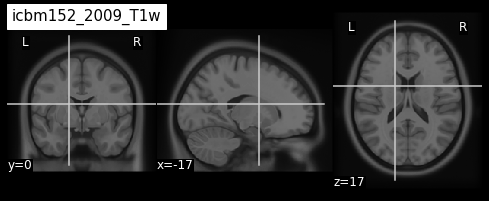

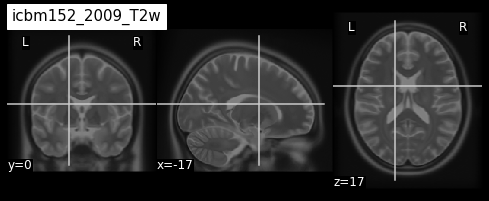

In [12]:
import nibabel as nib
from nilearn import plotting
from nilearn import datasets

atlas = datasets.fetch_icbm152_2009()
cut_coords = (-17, 0, 17)
atlas_t1 = atlas["t1"]
atlas_t1_img = nib.load(atlas_t1)

atlas_t2 = atlas["t2"]
atlas_t2_img = nib.load(atlas_t2)

plotting.plot_anat(atlas_t1_img, title="icbm152_2009_T1w", cut_coords=cut_coords, vmax=200)
plotting.plot_anat(atlas_t2_img, title="icbm152_2009_T2w", cut_coords=cut_coords, vmax=200)

Do the x,y,z coordinates for "subject space" vs. "template space" map to the same location in the brain?

fMRIPrep Example:

Text(0.5, 1.0, 'MNI reference space')

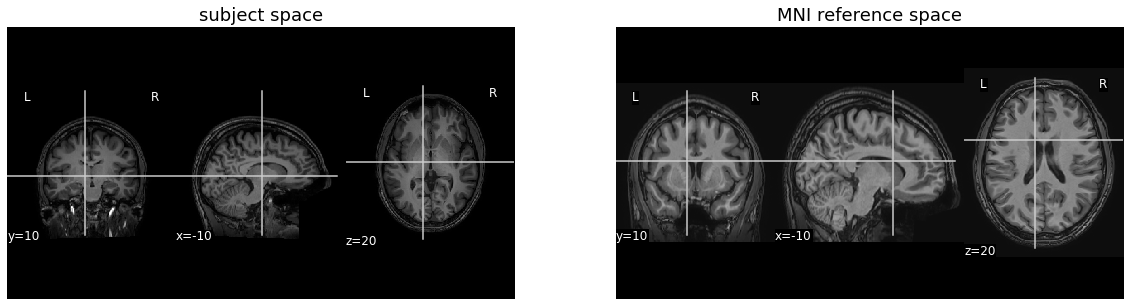

In [13]:
import matplotlib.pyplot as plt

cut_coords = (-10, 10, 20)

subject_T1 = bids_layout.get(subject="0001",
                             datatype="anat",
                             scope="raw",
                             extension="nii.gz",
                             return_type="filename")[0]
subject_T1_MNI_space = bids_layout.get(subject="0001",
                                       scope="derivatives",
                                       datatype="anat",
                                       suffix="T1w",
                                       space="MNI152NLin2009cAsym",
                                       desc="preproc",
                                       extension="nii.gz",
                                       return_type="filename")[0]

# plot

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(20, 5))
ax = axes[0]
vmax = 0.7 * nib.load(subject_T1).get_fdata().max() # adjust brightness
plotting.plot_anat(subject_T1, title="", cut_coords=cut_coords, vmax=vmax, axes=ax)
ax.set_title('subject space', fontsize=18)

ax=axes[1]
vmax = 0.7 * nib.load(subject_T1_MNI_space).get_fdata().max()
plotting.plot_anat(subject_T1_MNI_space, title="", cut_coords=cut_coords, vmax=vmax, axes=ax)
ax.set_title('MNI reference space', fontsize=18)

## 3. Image registration

A process that aligns an image from one coordinate space to another.

* Purpose
  * building templates
  * native (subject) space to template-space alignment (normalization)
  * inter-subject alignment (corhort specific)
  * intra-subject alignment (co-registration of image modalities or longitudinal analysis)
* Image similarity metrics
  * correlation ration (CR)
  * cross-correlation (CC)
  * mutual information (MI)
* Transforms
  * Linear: global feature alignment
    * Rigid (6 parameters): rotation, translation
    * Affine (12 parameters): rotation, translation, scaling, skewing
  * Nonlinear (a.k.a elastic): local feature aligment via warping
    * Computationally intensive deformation models with large number of parameters
    * Employ diffeomorphic models that preserve topology and source-target symmetry

Linear registrations are often used as an initialization step for non-linear registration.

![registration](imgs/Registration.png)

Commonly used algorithms:

| Algorithm | Deformation | ~ parameters |
|:---:|:---:|:---:|
| FSL FLIRT | Linear | 9 |
| ANIMAL | Non-linear (Local translation) | 69K |
| DARTEL Toolbox | Non-linear (diffeomorphic) | 6.4M |
| ANTs(SyN) | Non-linear (bi-directional diffeomorphic) | 28M |

* Rigid registration example:
  * The figure below shows the source image being registered to the target (left) in an iterative process. The optimized loss is shown on the right.
  ![rigid](imgs/registration_visualization_itk.gif)
* Non-linear deformation example:
  * The figure below shows local deformation (i.e. warping) of source image due to nonlinear registration.
  ![nonlinear](imgs/Silcer_DeformOnly.gif)

The deformation fields encode information regarding local morphometric brain changes. These can be quantified using “Jacobians” of the deformation field, and can be used to assess subtle morphometric differences between groups or timepoints.

FreeSurfer example on registration.

Text(0.5, 1.0, 'fsaverage reference space')

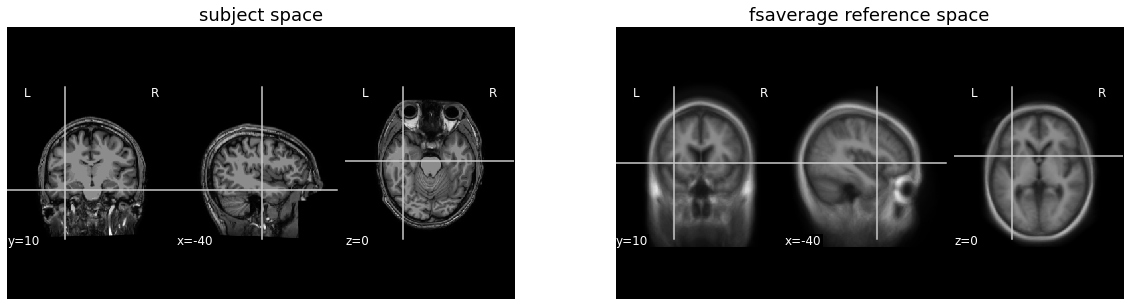

In [14]:
cut_coords = (-40,10,0)

# subject image
subject_T1 = freesurfer_output_dir + 'T1.mgz'

# fsaverage image
fsaverage_T1 = fsaverage_dir + "T1.mgz"

# plot
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,5))
ax=axes[0]
plotting.plot_anat(subject_T1, title="", cut_coords=cut_coords, vmax=200, axes=ax)
ax.set_title('subject space', fontsize=18)

ax=axes[1]
plotting.plot_anat(fsaverage_T1, title="", cut_coords=cut_coords, vmax=200, axes=ax)
ax.set_title('fsaverage reference space', fontsize=18)

How do we map a point-location (cross-hairs) from subject space to the reference space?

Use affine transform from the registration (for freesurfer: 'sub-0001/mri/transforms/talairach.xfm').

Subject space to refernce space mapping:
 (-40, 10, 0) --> (-41,-18,-21)




Text(0.5, 1.0, 'fsaverage reference space corresponding p=(-41,-18,-21)')

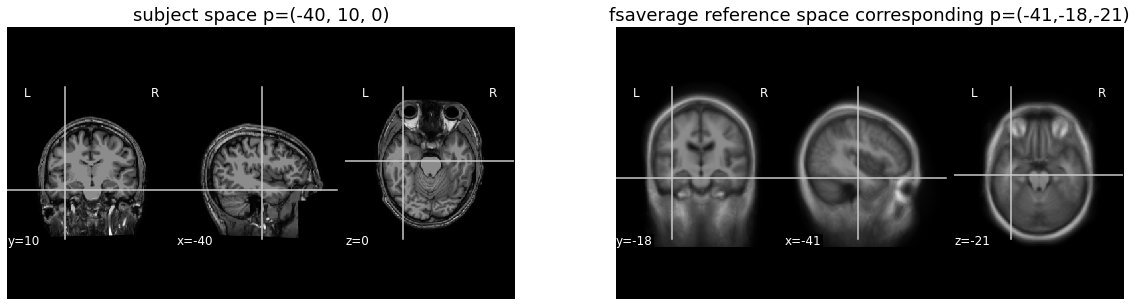

In [15]:
import numpy as np
from nibabel.affines import apply_affine

A = np.array([[1.027387, -0.011288, 0.022386, -0.672699],
              [-0.013200, 1.032273, 0.177898, -29.044456],
              [-0.052202, -0.149410, 1.149998, -22.219437],
              [0. ,0. , 0., 1.]])

cut_coords_affine_transformed = apply_affine(A, cut_coords)
x,y,z = cut_coords_affine_transformed
cut_coords_affine_transformed_str = "({},{},{})".format(int(x),int(y),int(z))

print("Subject space to refernce space mapping:\n {} --> {}\n\n".format(cut_coords,cut_coords_affine_transformed_str))
# plot
fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=(20,5))
ax=axes[0]
plotting.plot_anat(subject_T1, title="", cut_coords=cut_coords, vmax=200, axes=ax)
ax.set_title('subject space p={}'.format(cut_coords), fontsize=18)

ax=axes[1]
plotting.plot_anat(fsaverage_T1, title="", cut_coords=cut_coords_affine_transformed, vmax=200, axes=ax)
ax.set_title('fsaverage reference space corresponding p={}'.format(cut_coords_affine_transformed_str), fontsize=18)

### Subject space vs reference space: use cases

![sub_vs_common](imgs/Subject_vs_common_space.png)
